In [1]:
import numpy as np
import matplotlib.pyplot as plt
from temporal_random_walk import TemporalRandomWalk

def generate_bell_curve_temporal_graph(n_nodes=1000, n_edges=1_000_000, seed=42, time_range=1_000_000):
    np.random.seed(seed)

    # Bell-curve over node indices (higher probability for middle nodes)
    node_probs = np.exp(-0.5 * ((np.arange(n_nodes) - n_nodes / 2) / (n_nodes / 6)) ** 2)
    node_probs /= node_probs.sum()

    sources = np.random.choice(n_nodes, size=n_edges, p=node_probs)
    targets = np.random.choice(n_nodes, size=n_edges, p=node_probs)

    # Remove self-loops
    mask = sources != targets
    sources = sources[mask]
    targets = targets[mask]

    # Assign random timestamps in range [0, time_range)
    timestamps = np.random.randint(0, high=time_range, size=len(sources))

    return sources, targets, timestamps

def plot_node_distributions(edge_node_counts, walk_node_counts):
    nodes = np.arange(1000)

    plt.figure(figsize=(14, 6))

    plt.plot(nodes, edge_node_counts, label="Edge Participation Count", linewidth=2, alpha=0.8)
    plt.plot(nodes, walk_node_counts, label="Walk Visit Count", linewidth=2, alpha=0.8)
    plt.xlabel("Node ID")
    plt.ylabel("Frequency")
    plt.title("Node Participation: Edges vs Temporal Walks (Exponential Bias)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("plots/synthetic_uniform_walk_vs_edge_distribution.png")
    plt.show()

def run_bell_curve_walk_test():
    print("Generating graph...")
    sources, targets, timestamps = generate_bell_curve_temporal_graph()

    trw = TemporalRandomWalk(
        is_directed=False,
        use_gpu=False,
        max_time_capacity=-1,
        enable_weight_computation=True
    )
    trw.add_multiple_edges(sources, targets, timestamps)

    print("Sampling walks...")
    walks, _, walk_lengths = trw.get_random_walks_and_times(
        max_walk_len=100,
        walk_bias="ExponentialIndex",
        num_walks_total=1_000_000,
        initial_edge_bias="Uniform",
        walk_direction="Forward_In_Time"
    )

    print(f"Avg walk length: {walk_lengths.mean():.2f}")

    # --- Count nodes in edges
    edge_node_counts = np.zeros(1000)
    for node in np.concatenate([sources, targets]):
        edge_node_counts[node] += 1

    # --- Count nodes in walks
    valid_steps = walks[walks != -1]
    walk_node_counts = np.zeros(1000)
    for node in valid_steps:
        walk_node_counts[node] += 1

    # --- Normalize for shape comparability
    edge_node_counts /= edge_node_counts.max()
    walk_node_counts /= walk_node_counts.max()

    # --- Plot
    plot_node_distributions(edge_node_counts, walk_node_counts)


Generating graph...
Sampling walks...
Avg walk length: 96.30


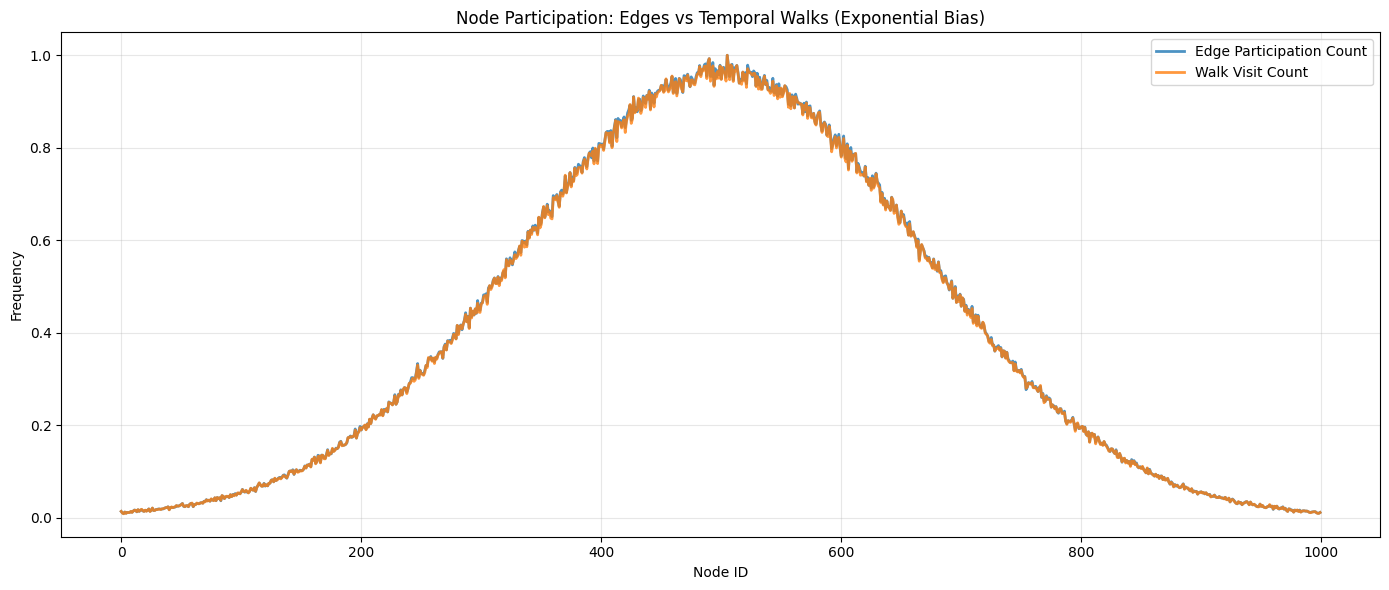

In [2]:
run_bell_curve_walk_test()

Generating graph...
ExponentialIndex → Avg walk length: 96.31
Linear → Avg walk length: 15.26
Uniform → Avg walk length: 9.96


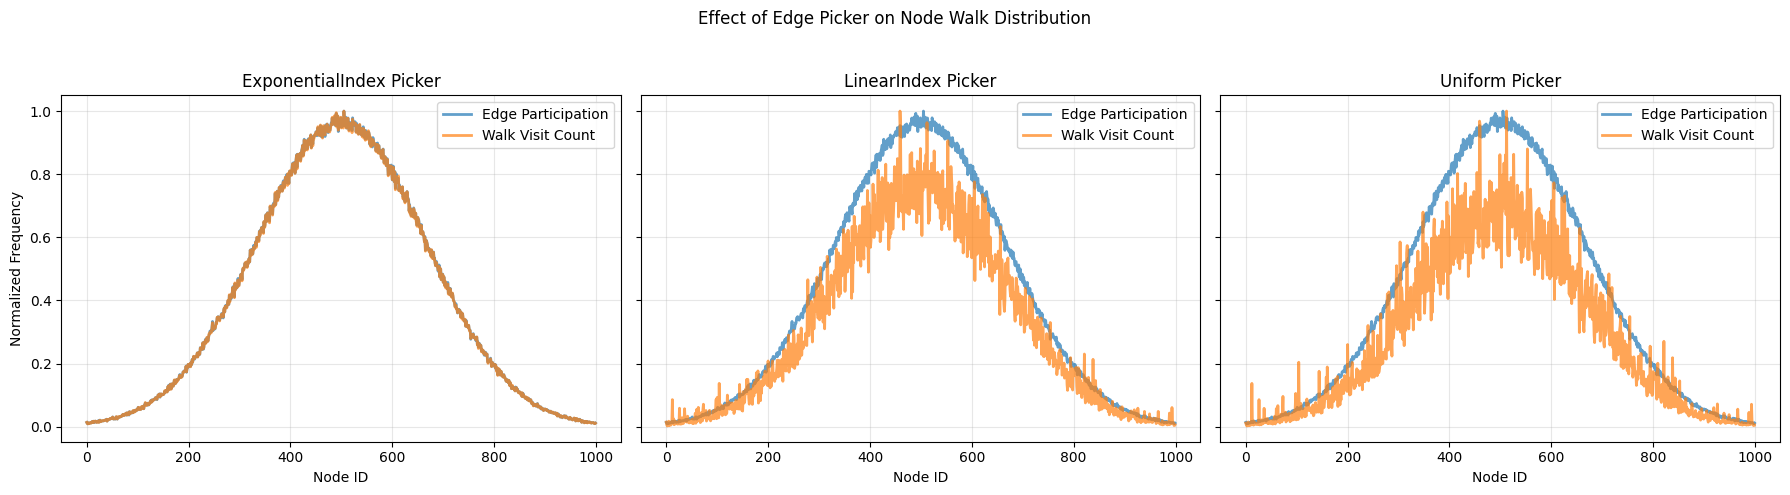

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from temporal_random_walk import TemporalRandomWalk

def generate_bell_curve_temporal_graph(n_nodes=1000, n_edges=1_000_000, seed=42, time_range=1_000_000):
    np.random.seed(seed)
    node_probs = np.exp(-0.5 * ((np.arange(n_nodes) - n_nodes / 2) / (n_nodes / 6)) ** 2)
    node_probs /= node_probs.sum()
    sources = np.random.choice(n_nodes, size=n_edges, p=node_probs)
    targets = np.random.choice(n_nodes, size=n_edges, p=node_probs)
    mask = sources != targets
    sources = sources[mask]
    targets = targets[mask]
    timestamps = np.random.randint(0, high=time_range, size=len(sources))
    return sources, targets, timestamps

def run_walk_sampling(edge_picker, sources, targets, timestamps, n_nodes=1000):
    trw = TemporalRandomWalk(
        is_directed=False,
        use_gpu=False,
        max_time_capacity=-1,
        enable_weight_computation=True
    )
    trw.add_multiple_edges(sources, targets, timestamps)

    walks, _, walk_lengths = trw.get_random_walks_and_times(
        max_walk_len=100,
        walk_bias=edge_picker,
        num_walks_total=1_000_000,
        initial_edge_bias="Uniform",
        walk_direction="Forward_In_Time"
    )

    print(f"{edge_picker} → Avg walk length: {walk_lengths.mean():.2f}")

    edge_node_counts = np.zeros(n_nodes)
    for node in np.concatenate([sources, targets]):
        edge_node_counts[node] += 1

    valid_steps = walks[walks != -1]
    walk_node_counts = np.zeros(n_nodes)
    for node in valid_steps:
        walk_node_counts[node] += 1

    edge_node_counts /= edge_node_counts.max()
    walk_node_counts /= walk_node_counts.max()

    return edge_node_counts, walk_node_counts

def plot_all_distributions(results, n_nodes=1000):
    pickers = ["ExponentialIndex", "LinearIndex", "Uniform"]
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, (edge_counts, walk_counts) in enumerate(results):
        axs[i].plot(np.arange(n_nodes), edge_counts, label="Edge Participation", linewidth=2, alpha=0.7)
        axs[i].plot(np.arange(n_nodes), walk_counts, label="Walk Visit Count", linewidth=2, alpha=0.7)
        axs[i].set_title(f"{pickers[i]} Picker")
        axs[i].set_xlabel("Node ID")
        if i == 0:
            axs[i].set_ylabel("Normalized Frequency")
        axs[i].legend()
        axs[i].grid(True, alpha=0.3)

    plt.suptitle("Effect of Edge Picker on Node Walk Distribution")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("plots/walk_distribution_comparison.png")
    plt.show()

def run_bell_curve_walk_distribution_experiment():
    print("Generating graph...")
    sources, targets, timestamps = generate_bell_curve_temporal_graph()
    pickers = ["ExponentialIndex", "Linear", "Uniform"]
    results = []

    for picker in pickers:
        edge_counts, walk_counts = run_walk_sampling(picker, sources, targets, timestamps)
        results.append((edge_counts, walk_counts))

    plot_all_distributions(results)

# Run it
run_bell_curve_walk_distribution_experiment()


In [5]:
import pandas as pd
import os

data_dir = '/Users/ashfaqsalehin/Downloads/TEA-datasets/datasets'

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'out.wikipedia-growth'),
                               sep=r'\s+',
                               skiprows=2,
                               header=None,
                               names=['u', 'i', 'x', 'ts'])

In [7]:
df

,u,i,x,ts
0,1,3,1,982623600
1,4,5,1,982623600
2,1,6,1,982710000
3,1,7,1,982710000
4,1,8,1,982710000
...,...,...,...,...
39953139,1870449,477195,1,1175810400
39953140,889373,415129,1,1175810400
39953141,889373,1870666,1,1175810400
39953142,259241,244935,1,1175810400


In [8]:
df[['u', 'i', 'ts']].to_csv('/Users/ashfaqsalehin/Downloads/TEA-datasets/csv_datasets/growth.csv', index=False)